## Imports

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style="white", palette="colorblind", font_scale=1.2, 
        rc={"figure.figsize":(12,9)})
import pandas as pd
import numpy as np
import re
from pandas.api.types import is_string_dtype, is_numeric_dtype
import os
import sys
import time


from pandas_summary import DataFrameSummary
from IPython.display import display

import sklearn
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV


from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Activation

Using TensorFlow backend.


In [3]:
PATH = "data/"

In [4]:
!ls {PATH}

'20190325 - data science exercise - data description.txt'
'20190325 - data science exercise.xlsx'


## Functions
The followings are helper functions from **fast.ai** library

In [5]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)
        
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(9,6), legend=False, color='cornflowerblue')
  
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

def add_datepart(df, fldname, drop=True, time=False, errors="raise"):   
    """add_datepart converts a column of df from a datetime64 to many columns containing
    the information from the date. This applies changes inplace.
    Parameters:
    -----------
    df: A pandas data frame. df gain several new columns.
    fldname: A string that is the name of the date column you wish to expand.
        If it is not a datetime64 series, it will be converted to one with pd.to_datetime.
    drop: If true then the original date column will be removed.
    time: If true time features: Hour, Minute, Second will be added.
    Examples:
    ---------
    >>> df = pd.DataFrame({ 'A' : pd.to_datetime(['3/11/2000', '3/12/2000', '3/13/2000'], infer_datetime_format=False) })
    >>> df
        A
    0   2000-03-11
    1   2000-03-12
    2   2000-03-13
    >>> add_datepart(df, 'A')
    >>> df
        AYear AMonth AWeek ADay ADayofweek ADayofyear AIs_month_end AIs_month_start AIs_quarter_end AIs_quarter_start AIs_year_end AIs_year_start AElapsed
    0   2000  3      10    11   5          71         False         False           False           False             False        False          952732800
    1   2000  3      10    12   6          72         False         False           False           False             False        False          952819200
    2   2000  3      11    13   0          73         False         False           False           False             False        False          952905600
    """
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True, errors=errors)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop: df.drop(fldname, axis=1, inplace=True)

def proc_df(df, y_fld=None, skip_flds=None, ignore_flds=None, do_scale=False, na_dict=None,
            preproc_fn=None, max_n_cat=None, subset=None, mapper=None):
    """ proc_df takes a data frame df and splits off the response variable, and
    changes the df into an entirely numeric dataframe.
    Parameters:
    -----------
    df: The data frame you wish to process.
    y_fld: The name of the response variable
    skip_flds: A list of fields that dropped from df.
    ignore_flds: A list of fields that are ignored during processing.
    do_scale: Standardizes each column in df. Takes Boolean Values(True,False)
    na_dict: a dictionary of na columns to add. Na columns are also added if there
        are any missing values.
    preproc_fn: A function that gets applied to df.
    max_n_cat: The maximum number of categories to break into dummy values, instead
        of integer codes.
    subset: Takes a random subset of size subset from df.
    mapper: If do_scale is set as True, the mapper variable
        calculates the values used for scaling of variables during training time (mean and standard deviation).
    Returns:
    --------
    [x, y, nas, mapper(optional)]:
        x: x is the transformed version of df. x will not have the response variable
            and is entirely numeric.
        y: y is the response variable
        nas: returns a dictionary of which nas it created, and the associated median.
        mapper: A DataFrameMapper which stores the mean and standard deviation of the corresponding continuous
        variables which is then used for scaling of during test-time.
    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['a', 'b', 'a']})
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    note the type of col2 is string
    >>> train_cats(df)
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    now the type of col2 is category { a : 1, b : 2}
    >>> x, y, nas = proc_df(df, 'col1')
    >>> x
       col2
    0     1
    1     2
    2     1
    >>> data = DataFrame(pet=["cat", "dog", "dog", "fish", "cat", "dog", "cat", "fish"],
                 children=[4., 6, 3, 3, 2, 3, 5, 4],
                 salary=[90, 24, 44, 27, 32, 59, 36, 27])
    >>> mapper = DataFrameMapper([(:pet, LabelBinarizer()),
                          ([:children], StandardScaler())])
    >>>round(fit_transform!(mapper, copy(data)), 2)
    8x4 Array{Float64,2}:
    1.0  0.0  0.0   0.21
    0.0  1.0  0.0   1.88
    0.0  1.0  0.0  -0.63
    0.0  0.0  1.0  -0.63
    1.0  0.0  0.0  -1.46
    0.0  1.0  0.0  -0.63
    1.0  0.0  0.0   1.04
    0.0  0.0  1.0   0.21
    """
    if not ignore_flds: ignore_flds=[]
    if not skip_flds: skip_flds=[]
    if subset: pass
    else: df = df.copy()
    ignored_flds = df.loc[:, ignore_flds]
    df.drop(ignore_flds, axis=1, inplace=True)
    if preproc_fn: pass
    if y_fld is None: y = None
    else:
        if not is_numeric_dtype(df[y_fld]): df[y_fld] = df[y_fld].cat.codes
        y = df[y_fld].values
        skip_flds += [y_fld]
    df.drop(skip_flds, axis=1, inplace=True)

    if na_dict is None: na_dict = {}
    else: na_dict = na_dict.copy()
    na_dict_initial = na_dict.copy()
    for n,c in df.items(): na_dict = fix_missing(df, c, n, na_dict)
    if len(na_dict_initial.keys()) > 0:
        df.drop([a + '_na' for a in list(set(na_dict.keys()) - set(na_dict_initial.keys()))], axis=1, inplace=True)
    if do_scale: pass
    for n,c in df.items(): numericalize(df, c, n, max_n_cat)
    df = pd.get_dummies(df, dummy_na=True)
    df = pd.concat([ignored_flds, df], axis=1)
    res = [df, y, na_dict]
    if do_scale: pass
    return res

def numericalize(df, col, name, max_n_cat):
    """ Changes the column col from a categorical type to it's integer codes.
    Parameters:
    -----------
    df: A pandas dataframe. df[name] will be filled with the integer codes from
        col.
    col: The column you wish to change into the categories.
    name: The column name you wish to insert into df. This column will hold the
        integer codes.
    max_n_cat: If col has more categories than max_n_cat it will not change the
        it to its integer codes. If max_n_cat is None, then col will always be
        converted.
    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['a', 'b', 'a']})
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    note the type of col2 is string
    >>> train_cats(df)
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    now the type of col2 is category { a : 1, b : 2}
    >>> numericalize(df, df['col2'], 'col3', None)
       col1 col2 col3
    0     1    a    1
    1     2    b    2
    2     3    a    1
    """
    if not is_numeric_dtype(col) and ( max_n_cat is None or len(col.cat.categories)>max_n_cat):
        df[name] = col.cat.codes+1

def fix_missing(df, col, name, na_dict):
    """ Fill missing data in a column of df with the median, and add a {name}_na column
    which specifies if the data was missing.
    Parameters:
    -----------
    df: The data frame that will be changed.
    col: The column of data to fix by filling in missing data.
    name: The name of the new filled column in df.
    na_dict: A dictionary of values to create na's of and the value to insert. If
        name is not a key of na_dict the median will fill any missing data. Also
        if name is not a key of na_dict and there is no missing data in col, then
        no {name}_na column is not created.
    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, np.NaN, 3], 'col2' : [5, 2, 2]})
    >>> df
       col1 col2
    0     1    5
    1   nan    2
    2     3    2
    >>> fix_missing(df, df['col1'], 'col1', {})
    >>> df
       col1 col2 col1_na
    0     1    5   False
    1     2    2    True
    2     3    2   False
    >>> df = pd.DataFrame({'col1' : [1, np.NaN, 3], 'col2' : [5, 2, 2]})
    >>> df
       col1 col2
    0     1    5
    1   nan    2
    2     3    2
    >>> fix_missing(df, df['col2'], 'col2', {})
    >>> df
       col1 col2
    0     1    5
    1   nan    2
    2     3    2
    >>> df = pd.DataFrame({'col1' : [1, np.NaN, 3], 'col2' : [5, 2, 2]})
    >>> df
       col1 col2
    0     1    5
    1   nan    2
    2     3    2
    >>> fix_missing(df, df['col1'], 'col1', {'col1' : 500})
    >>> df
       col1 col2 col1_na
    0     1    5   False
    1   500    2    True
    2     3    2   False
    """
    if is_numeric_dtype(col):
        if pd.isnull(col).sum() or (name in na_dict):
            df[name+'_na'] = pd.isnull(col)
            filler = na_dict[name] if name in na_dict else col.median()
            df[name] = col.fillna(filler)
            na_dict[name] = filler
    return na_dict

def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

## The data

### Look at the data

This dataset represents the evolution of US bonds interest rates with different maturities. The dataset contains timeseries for
- bonds interest rates: GT2 Govt, GT5 Govt, GT10 Govt, Effective Federal Funds Rate;
- indices: LUATTRUU, TYVIX;
- precomputed features: Slope 10-2, Slope 5-2, Slope 10-5, Curvature 10-5-2;
- the target variable: Rising rates.


The key fields are:

- Dates: date of the data point in format DD/MM/YYYY
- GT2 Govt: bonds interest rate with maturity 2 years
- GT5 Govt: bonds interest rate with maturity 5 years
- GT10 Govt: bonds interest rate with maturity 10 years
- LUATTRUU Index: bond index (see https://www.bloomberg.com/quote/LUATTRUU:IND)
- TYVIX Index: Treasury Note Volatility Index (see http://www.cboe.com/products/vix-index-volatility/volatility-on-interest-rates/cboe-cbot-10-year-u-s-treasury-note-volatility-index-tyvix)
- Slope 10-2: difference between GT10 Govt and GT2 Govt
- Slope 5-2: difference between GT5 Govt and GT2 Govt
- Slope 10-5: difference between GT10 Govt and GT5 Govt
- Curvature 10-5-2: curvature of the yield curve (see https://www.investopedia.com/terms/y/yieldcurve.asp)
- Effective Federal Funds Rate: interbank interest rate for overnight loans
- Rising rates: binary flag that indicates whether the interest rates are rising 



Now it's **important to look at the data** to understand the format and what type of values it holds, etc. 

In [6]:
df_raw = pd.read_excel(f'{PATH}20190325 - data science exercise.xlsx', parse_dates=["Dates"])
df_raw['Rising rates'].fillna(0, inplace=True)

Positive examples = 7650
Negative examples = 9216
Proportion of positive to negative examples = 83.01%


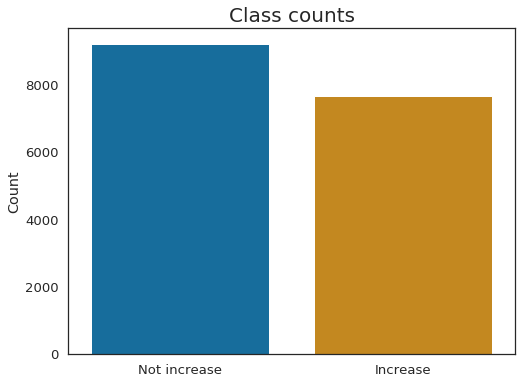

In [7]:
# Get number of positve and negative examples
pos = df_raw[df_raw["Rising rates"] == 1].shape[0]
neg = df_raw[df_raw["Rising rates"] == 0].shape[0]
print(f"Positive examples = {pos}")
print(f"Negative examples = {neg}")
print(f"Proportion of positive to negative examples = {(pos / neg) * 100:.2f}%")
plt.figure(figsize=(8, 6))
sns.countplot(df_raw["Rising rates"])
plt.xticks((0, 1), ["Not increase", "Increase"])
plt.xlabel("")
plt.ylabel("Count")
plt.title("Class counts", y=1, fontdict={"fontsize": 20});

In [8]:
display_all(df_raw.tail().T)

,16861,16862,16863,16864,16865
Dates,2019-02-15 00:00:00,2019-02-18 00:00:00,2019-02-19 00:00:00,2019-02-20 00:00:00,2019-02-21 00:00:00
GT2 Govt,2.517,2.517,2.489,2.499,2.513
GT5 Govt,2.494,2.494,2.458,2.469,2.485
GT10 Govt,2.664,2.664,2.635,2.646,2.662
LUATTRUU Index,2227.4,2227.4,2230.15,2229.3,2229.3
TYVIX Index,3.42,3.42,3.64,3.47,3.47
Slope 10-2,0.018375,0.018375,0.01825,0.018375,0.018625
Slope 5-2,-0.00766667,-0.00766667,-0.0103333,-0.01,-0.00933333
Slope 10-5,0.034,0.034,0.0354,0.0354,0.0354
Curvature 10-5-2,0.00520833,0.00520833,0.00571667,0.005675,0.00559167


In [9]:
display_all(df_raw.describe(include='all').T)

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
Dates,16866,16866,1967-09-20 00:00:00,1,1954-07-01 00:00:00,2019-02-21 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GT2 Govt,10974,NaN,NaN,NaN,NaN,NaN,5.31953,3.79335,0.155,1.83,5.181,7.7645,16.959
GT5 Govt,10974,NaN,NaN,NaN,NaN,NaN,5.82956,3.51447,0.543,2.78525,5.606,8.108,16.274
GT10 Govt,10974,NaN,NaN,NaN,NaN,NaN,6.26934,3.24172,1.359,3.69325,5.864,8.34175,15.842
LUATTRUU Index,10974,NaN,NaN,NaN,NaN,NaN,1024.22,703.241,131.65,376.06,905.25,1653.78,2259.66
TYVIX Index,4211,NaN,NaN,NaN,NaN,NaN,6.281,2.05806,3.16,4.775,5.7,7.56,14.72
Slope 10-2,10974,NaN,NaN,NaN,NaN,NaN,0.118726,0.11601,-0.302125,0.032625,0.115375,0.203969,0.36375
Slope 5-2,10974,NaN,NaN,NaN,NaN,NaN,0.170012,0.179829,-0.571667,0.0430833,0.161667,0.301333,0.544
Slope 10-5,10974,NaN,NaN,NaN,NaN,NaN,0.0879551,0.0853129,-0.1804,0.0232,0.0764,0.14475,0.2984
Curvature 10-5-2,10974,NaN,NaN,NaN,NaN,NaN,-0.0102571,0.0146458,-0.0600083,-0.0215083,-0.00898333,-0.000841667,0.059325


In [10]:
display_all(df_raw.isnull().sum().sort_index()/len(df_raw))

Curvature 10-5-2                0.349342
Dates                           0.000000
Effective Federal Funds Rate    0.000000
GT10 Govt                       0.349342
GT2 Govt                        0.349342
GT5 Govt                        0.349342
LUATTRUU Index                  0.349342
Rising rates                    0.000000
Slope 10-2                      0.349342
Slope 10-5                      0.349342
Slope 5-2                       0.349342
TYVIX Index                     0.750326
dtype: float64

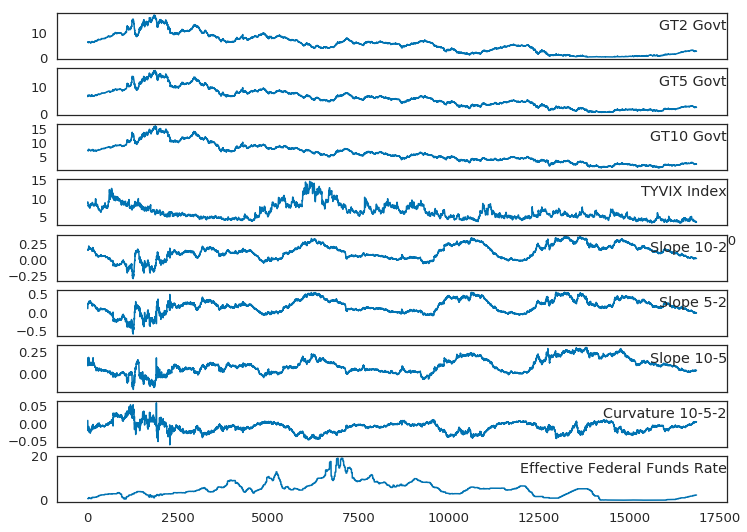

In [11]:
# specify variables to plot
groups = [1, 2, 3, 5, 6, 7, 8, 9, 10]
i = 1
# plot each variable
plt.figure()
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(df_raw.iloc[:, group])
    plt.title(df_raw.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

### Initial processing

This dataset contains only **continuous** variables.
It is said that "You should always consider this feature extraction step when working with date-time. Without expanding your date-time into these additional fields, you can't capture any trend/cyclical behavior as a function of time at any of these granularities."

The add_datepart method extracts particular date fields from a complete datetime for the purpose of constructing categoricals. Followings are some of the information we can extract from date — year, month, quarter, day of month, day of week, week of year, is it a holiday? weekend? etc.

In [12]:
add_datepart(df_raw, 'Dates')
df_raw.DatesYear.head()

0    1954
1    1954
2    1954
3    1954
4    1954
Name: DatesYear, dtype: int64

For numeric data type, we check if there is null column. If so, the proc_df will create a new column with a name with _na appended at the end and set it to 1 if it is missing; 0 otherwise (boolean). It will then replace the missing value with a median.

In [13]:
df, y, nas = proc_df(df_raw, 'Rising rates')

We store the file so that we can accessed efficiently later on.

In [14]:
os.makedirs('tmp', exist_ok=True)
df.to_feather('tmp/exercise-raw')

Since now on we can simply read it.

In [15]:
df_raw = pd.read_feather('tmp/exercise-raw')

## Define the problem

- Inputs vs. Outputs: I will build a model to predict rising rates for one year time step given the historical data of the evolution of US bonds interest rates with different maturities
- Regression vs. Classification: this is binary classification 
- Univariate vs. Multivariate: there are multiple input variables, so this is multivariate time series problem
- Single-step vs. Multi-step: I will build a multi-step forecast model for 365 days time step
- Static vs. Dynamic: The model is static which is fit once and used to make predictions for the next 365 days.

## Design train and validation set

We need to create a validation set that has the time series properties. This means the validation set need to be of separate time period as well. 
Here the validation set will be data from 2018.

In [16]:
df[df.DatesYear>=2018].shape

(299, 32)

In [17]:
n_valid = 299 
n_trn = len(df)-n_valid
raw_train, raw_valid = split_vals(df_raw, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((16567, 32), (16567,), (299, 32))

### Add lagged features (the outcomes of the past 20 days)

In [18]:
def add_lagged_features(df, y, n_in=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
    df: time series data
    y: outcome
    n_in: Number of lag observations as input (X).    
    dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed .
    """  
    df_agg = df.copy()
    y_agg = y.copy()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        new_column = f'var(t-{i})'        
        df_agg[new_column] = np.array(pd.Series(y).shift(i))       
    
    # drop rows with NaN values
    if dropnan:
        df_agg.dropna(inplace=True)
        y_agg = y[n_in:]
    return [df_agg, y_agg]

X_train_lagged, y_train_lagged = add_lagged_features(X_train, y_train, 20)

## Feature Importance with Random Forests

In [19]:
m = RandomForestClassifier(n_estimators=20, n_jobs=-1)
m.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [20]:
fi = rf_feat_importance(m, X_train); fi[:10]

,cols,imp
22,DatesElapsed,0.266724
10,DatesYear,0.184149
9,Effective Federal Funds Rate,0.132242
3,LUATTRUU Index,0.095023
5,Slope 10-2,0.040290
7,Slope 10-5,0.039766
0,GT2 Govt,0.038638
2,GT10 Govt,0.037307
6,Slope 5-2,0.026491
15,DatesDayofyear,0.022259


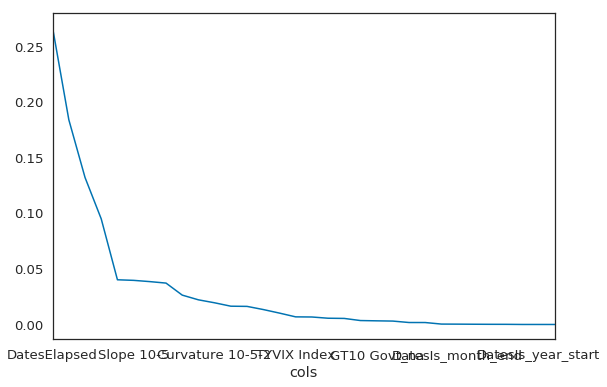

In [21]:
fi.plot('cols', 'imp', figsize=(9,6), legend=False);

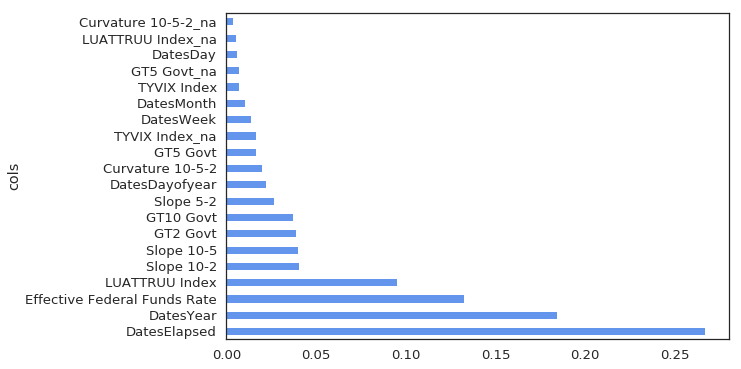

In [22]:
plot_fi(fi[:20]);

## Cross Validation on Time Series

When working with time series data, traditional cross-validation (like k-fold) does not work since there are temporal dependencies.
Here I use Nested Cross-Validation. Specifically, the train data will be slplited into 10 folds. 
- Train the model on fold 1 then forecasting the interest rate rising for the next 365 days. 
- Train the model on fold 1 + 2 then forecasting the interest rate rising for the next 365 days. 
- Train the model on fold 1 + 2 + 3 then forecasting the interest rate rising for the next 365 days 
- ...

Then the accuracy for each test will be captured and the accuracy mean is used to decide which model is better than the other. The *performClassification* function from Francesco's blog implement the idea.
Models for testing include Random Forest, Gradient Boosing and Multilayer Perceptron Neural Networks.

In [23]:
def create_mlp(n_features):
    model = Sequential()
    model.add(Dense(64, input_dim=n_features, kernel_initializer='normal', activation='relu'))
    model.add(Dense(32, kernel_initializer='normal', activation='relu'))
    model.add(Dense(16, kernel_initializer='normal', activation='relu'))
    #model.add(Dense(8, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def performClassification(X_trainFolds, y_trainFolds, X_testFolds, y_testFolds, n_features, algorithm, parameters):
    if algorithm == "MLP":
        m = create_mlp(n_features)
        m.fit(X_trainFolds, y_trainFolds)
        y_pred = m.predict_classes(X_testFolds)
    elif algorithm == "GB":
        m = GradientBoostingClassifier()
        m.fit(X_trainFolds, y_trainFolds)
        y_pred = m.predict(X_testFolds)
    else:
        m = RandomForestClassifier(n_estimators=20, n_jobs=-1)
        #m = GradientBoostingClassifier()
        m.fit(X_trainFolds, y_trainFolds)
        y_pred = m.predict(X_testFolds)    
        
    unique, counts = np.unique(y_pred, return_counts=True)
    print(dict(zip(unique, counts)))

    return sklearn.metrics.accuracy_score(y_testFolds, y_pred)

def performTimeSeriesCV(X_train, y_train, n_features, number_folds, algorithm, parameters):
    """
    Given X_train and y_train (the test set is excluded from the Cross Validation),
    number of folds, the ML algorithm to implement and the parameters to test,
    the function acts based on the following logic: it splits X_train and y_train in a
    number of folds equal to number_folds. Then train on one fold and tests accuracy
    on the consecutive as follows:
    - Train on fold 1, test on 2
    - Train on fold 1-2, test on 3
    - Train on fold 1-2-3, test on 4
    ....
    Returns mean of test accuracies.
    """

    print (f'Parameters --------------------------------> {parameters}')
    print (f'Size train set: {X_train.shape}')
    
    # k is the size of each fold. It is computed dividing the number of 
    # rows in X_train by number_folds. This number is floored and coerced to int
    k = int(np.floor(float(X_train.shape[0]) / number_folds))
    print (f'Size of each fold: {k}')
    
    # initialize to zero the accuracies array. It is important to stress that
    # in the CV of Time Series if I have n folds I test n-1 folds as the first
    # one is always needed to train
    accuracies = np.zeros(number_folds-1)

    # loop from the first 2 folds to the total number of folds    
    for i in range(2, number_folds + 1):
        print ('')
        
        # the split is the percentage at which to split the folds into train
        # and test. For example when i = 2 we are taking the first 2 folds out 
        # of the total available. In this specific case we have to split the
        # two of them in half (train on the first, test on the second), 
        # so split = 1/2 = 0.5 = 50%. When i = 3 we are taking the first 3 folds 
        # out of the total available, meaning that we have to split the three of them
        # in two at split = 2/3 = 0.66 = 66% (train on the first 2 and test on the
        # following)
        split = float(i-1)/i
        
        # example with i = 4 (first 4 folds):
        #      Splitting the first       4        chunks at          3      /        4
        print ('Splitting the first ' + str(i) + ' chunks at ' + str(i-1) + '/' + str(i)) 
        
        # as we loop over the folds X and y are updated and increase in size.
        # This is the data that is going to be split and it increases in size 
        # in the loop as we account for more folds. If k = 300, with i starting from 2
        # the result is the following in the loop
        # i = 2
        # X = X_train[:(600)]
        # y = y_train[:(600)]
        #
        # i = 3
        # X = X_train[:(900)]
        # y = y_train[:(900)]
        # .... 
        X = X_train[:(k*i)]
        y = y_train[:(k*i)]
        print (f'Size of train + test: {X.shape}') # the size of the dataframe is going to be k*i

        # X and y contain both the folds to train and the fold to test.
        # index is the integer telling us where to split, according to the
        # split percentage we have set above
        index = int(np.floor(X.shape[0] * split))
        
        # folds used to train the model        
        X_trainFolds = X[:index]        
        y_trainFolds = y[:index]
        
        # fold used to test the model
        X_testFolds = X[(index + 1):(index + 366)]
        y_testFolds = y[(index + 1):(index + 366)]
        #print(y_testFolds)
        
        # i starts from 2 so the zeroth element in accuracies array is i-2. performClassification() is a function which takes care of a classification problem. This is only an example and you can replace this function with whatever ML approach you need.
        accuracies[i-2] = performClassification(X_trainFolds, y_trainFolds, X_testFolds, y_testFolds, n_features, algorithm, parameters)
        #accuracies[i-2] = performClassification(X_trainFolds, y_trainFolds, X_testFolds, y_testFolds, algorithm, parameters)
        
        # example with i = 4:
        #      Accuracy on fold         4     :    0.85423
        print ('Accuracy on fold ' + str(i) + ': ' + str(accuracies[i-2]))
    
    # the function returns the mean of the accuracy on the n-1 folds    
    return accuracies.mean()

### Do cross validation on X_train and y-train

In [24]:
performTimeSeriesCV(X_train, y_train, 32, 10, 'RF', [])

Parameters --------------------------------> []
Size train set: (16567, 32)
Size of each fold: 1656

Splitting the first 2 chunks at 1/2
Size of train + test: (3312, 32)
{0.0: 365}
Accuracy on fold 2: 0.5232876712328767

Splitting the first 3 chunks at 2/3
Size of train + test: (4968, 32)
{0.0: 365}
Accuracy on fold 3: 0.4547945205479452

Splitting the first 4 chunks at 3/4
Size of train + test: (6624, 32)
{1.0: 365}
Accuracy on fold 4: 0.6273972602739726

Splitting the first 5 chunks at 4/5
Size of train + test: (8280, 32)
{1.0: 365}
Accuracy on fold 5: 0.7972602739726027

Splitting the first 6 chunks at 5/6
Size of train + test: (9936, 32)
{0.0: 365}
Accuracy on fold 6: 0.4273972602739726

Splitting the first 7 chunks at 6/7
Size of train + test: (11592, 32)
{0.0: 365}
Accuracy on fold 7: 1.0

Splitting the first 8 chunks at 7/8
Size of train + test: (13248, 32)
{0.0: 236, 1.0: 129}
Accuracy on fold 8: 0.35342465753424657

Splitting the first 9 chunks at 8/9
Size of train + test: (14

0.6724505327245054

### Do cross validation on X_train_lagged and y-train_lagged (after adding lagged features)

In [25]:
performTimeSeriesCV(X_train_lagged, y_train_lagged, 52, 10, 'RF', [])

Parameters --------------------------------> []
Size train set: (16547, 52)
Size of each fold: 1654

Splitting the first 2 chunks at 1/2
Size of train + test: (3308, 52)
{0.0: 175, 1.0: 190}
Accuracy on fold 2: 0.9945205479452055

Splitting the first 3 chunks at 2/3
Size of train + test: (4962, 52)
{0.0: 151, 1.0: 214}
Accuracy on fold 3: 0.9972602739726028

Splitting the first 4 chunks at 3/4
Size of train + test: (6616, 52)
{0.0: 47, 1.0: 318}
Accuracy on fold 4: 0.7178082191780822

Splitting the first 5 chunks at 4/5
Size of train + test: (8270, 52)
{1.0: 365}
Accuracy on fold 5: 0.7643835616438356

Splitting the first 6 chunks at 5/6
Size of train + test: (9924, 52)
{0.0: 148, 1.0: 217}
Accuracy on fold 6: 0.9945205479452055

Splitting the first 7 chunks at 6/7
Size of train + test: (11578, 52)
{0.0: 365}
Accuracy on fold 7: 1.0

Splitting the first 8 chunks at 7/8
Size of train + test: (13232, 52)
{1.0: 365}
Accuracy on fold 8: 1.0

Splitting the first 9 chunks at 8/9
Size of trai

0.9406392694063928

So the model's accuracy improve sifinicantly by adding lagged fetures to the data (**it is now capable of learning trend from the data**). Now let's see how it work on the validation set

In [26]:
m = RandomForestClassifier(n_estimators=20, n_jobs=-1)
m.fit(X_train_lagged, y_train_lagged)
X_valid_lagged, y_valid_lagged = add_lagged_features(X_valid, y_valid, 20)
y_pred = m.predict(X_valid_lagged)
sklearn.metrics.accuracy_score(y_valid_lagged, y_pred)

1.0

### Let's do it with GB

In [28]:
performTimeSeriesCV(X_train, y_train, 32, 10, 'GB', [])

Parameters --------------------------------> []
Size train set: (16567, 32)
Size of each fold: 1656

Splitting the first 2 chunks at 1/2
Size of train + test: (3312, 32)
{0.0: 365}
Accuracy on fold 2: 0.5232876712328767

Splitting the first 3 chunks at 2/3
Size of train + test: (4968, 32)
{0.0: 365}
Accuracy on fold 3: 0.4547945205479452

Splitting the first 4 chunks at 3/4
Size of train + test: (6624, 32)
{1.0: 365}
Accuracy on fold 4: 0.6273972602739726

Splitting the first 5 chunks at 4/5
Size of train + test: (8280, 32)
{1.0: 365}
Accuracy on fold 5: 0.7972602739726027

Splitting the first 6 chunks at 5/6
Size of train + test: (9936, 32)
{0.0: 365}
Accuracy on fold 6: 0.4273972602739726

Splitting the first 7 chunks at 6/7
Size of train + test: (11592, 32)
{0.0: 365}
Accuracy on fold 7: 1.0

Splitting the first 8 chunks at 7/8
Size of train + test: (13248, 32)
{1.0: 365}
Accuracy on fold 8: 1.0

Splitting the first 9 chunks at 8/9
Size of train + test: (14904, 32)
{1.0: 365}
Accura

0.7442922374429224

In [29]:
performTimeSeriesCV(X_train_lagged, y_train_lagged, 52, 10, 'GB', [])

Parameters --------------------------------> []
Size train set: (16547, 52)
Size of each fold: 1654

Splitting the first 2 chunks at 1/2
Size of train + test: (3308, 52)
{0.0: 365}
Accuracy on fold 2: 0.473972602739726

Splitting the first 3 chunks at 2/3
Size of train + test: (4962, 52)
{0.0: 365}
Accuracy on fold 3: 0.410958904109589

Splitting the first 4 chunks at 3/4
Size of train + test: (6616, 52)
{0.0: 104, 1.0: 261}
Accuracy on fold 4: 0.3041095890410959

Splitting the first 5 chunks at 4/5
Size of train + test: (8270, 52)
{0.0: 1, 1.0: 364}
Accuracy on fold 5: 0.7671232876712328

Splitting the first 6 chunks at 5/6
Size of train + test: (9924, 52)
{0.0: 365}
Accuracy on fold 6: 0.4

Splitting the first 7 chunks at 6/7
Size of train + test: (11578, 52)
{0.0: 365}
Accuracy on fold 7: 1.0

Splitting the first 8 chunks at 7/8
Size of train + test: (13232, 52)
{0.0: 4, 1.0: 361}
Accuracy on fold 8: 0.989041095890411

Splitting the first 9 chunks at 8/9
Size of train + test: (14886

0.7038051750380517

The accuracy gets worst for GB. And how is about MLP?

In [30]:
performTimeSeriesCV(X_train, y_train, 32, 10, 'MLP', [])

Parameters --------------------------------> []
Size train set: (16567, 32)
Size of each fold: 1656

Splitting the first 2 chunks at 1/2
Size of train + test: (3312, 32)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/1
1656/1656 [==============================] - 0s 195us/step - loss: 11.8744 - acc: 0.2633
{0: 365}
Accuracy on fold 2: 0.5232876712328767

Splitting the first 3 chunks at 2/3
Size of train + test: (4968, 32)
Epoch 1/1
3312/3312 [==============================] - 0s 117us/step - loss: 3.4705 - acc: 0.7823
{1: 365}
Accuracy on fold 3: 0.5452054794520548

Splitting the first 4 chunks at 3/4
Size of train + test: (6624, 32)
Epoch 1/1
4968/4968 [==============================] - 1s 103us/step - loss: 5.7514 - acc: 0.6403
{0: 365}
Accuracy on fold 4: 0.3726027397260274

Splitting the first 5 chunks at 4/5
Size of train + test: (8280, 32)
Epoch 1/1
6624/6624 [==============================] - 1s 97u

0.5330289193302892

In [ ]:
performTimeSeriesCV(X_train_lagged, y_train_lagged, 52, 10, 'MLP', [])

## Removing least important features and do cross validation again

In [ ]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)

X_train = X_train[to_keep].copy()
X_valid = X_valid[to_keep].copy()

X_train.shape, X_valid.shape

In [ ]:
performTimeSeriesCV(X_train, y_train, 16, 10, 'RF', [])

In [ ]:
performTimeSeriesCV(X_train, y_train, 16, 10, 'GB', [])

In [ ]:
performTimeSeriesCV(X_train, y_train, 16, 10, 'MLP', [])